In [1]:
import pandas as pd

# Read the CSV file into a DataFrame  freetown_deeplab_confidence_processed.csv
df = pd.read_csv('/teamspace/studios/this_studio/Deeplab/pilot_eastafrica_haiti_freetown_WITH_deeplab_crf_sam.csv')

file_list = df['File'].tolist()
print(len(file_list))
print(file_list[0])


7071
eastafrica/MANGINDI/2021.05.13.18.24.15_0.6394087399999999_32.741514642_9568af0c-d99b-408e-abe8-d8fcc5935d21_IMG_20210513_180043_9129715576474702323.jpg


In [2]:
import os
home = os.getcwd()

os.chdir('/teamspace/studios/this_studio/sam-hq')
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

os.chdir(home)



/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is no

<All keys matched successfully>


In [3]:
from dotenv import load_dotenv


env_path = '/teamspace/studios/this_studio/Deeplab/credentials.env'
load_dotenv(dotenv_path=env_path)
import boto3

%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab


In [4]:
bucket = get_s3_bucket('treetracker-training-images')
print(type(bucket))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'


<class 'boto3.resources.factory.s3.Bucket'>


In [5]:
def get_target(mask_path):
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    mask_array = (mask_array > 128).astype(np.uint8)
    mask_array = mask_array * 255
    mask = Image.fromarray(mask_array.astype(np.uint8))
    mask = mask_transform(mask)
    mask = torch.squeeze(mask, 0)
    mask = mask.to(device, dtype=torch.long)
    mask = mask.float()
    return mask.cpu().numpy()

def metrics_from_dataset(checkpoint, dataset_path):
    metrics = BinarySegMetrics()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    sample_dir = os.path.join(dataset_path, 'samples')
    mask_dir = os.path.join(dataset_path, 'binary_masks')
    
    file_list = os.listdir(sample_dir)
    
    for i in tqdm(file_list, desc="Processing images"):
        img_path = os.path.join(sample_dir, i)
        ext = os.path.basename(img_path).split('.')[-1]
        img_name = os.path.basename(img_path)[:-len(ext) - 1]
        mask_path = os.path.join(mask_dir, img_name + '_binarymask.' + ext)
        
        target = get_target(mask_path)
        img = Image.open(img_path)
        
        img_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)
    
        with torch.no_grad():
            output = model(img_tensor)
            output = torch.squeeze(output, dim=1)
            prob = torch.sigmoid(output).detach()
            pred = (prob > 0.5).long().cpu().numpy()[0]
            
        metrics.update(target, pred)
        
        # The following lines are commented out as they appear to be part of additional processing
        # denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # img_np = img_tensor[0].detach().cpu().numpy()
        # img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)
        # cleaned_mask = apply_dense_crf(img_np, np.array(decode_target(pred)))
        # prob_np = prob[0].cpu().numpy()
        # count = np.sum(prob_np > 0.5)
        # confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0
        
    return metrics.get_results()


In [10]:
metrics_from_dataset(downstreamed_large , '/teamspace/studios/this_studio/Deeplab/pilot_annotations_eastafrica_haiti_freetown')


Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth


Processing images: 100%|██████████| 244/244 [00:59<00:00,  4.08it/s]


{'Foreground Acc': 0.9380342308466383,
 'Precision': 0.7545361416772415,
 'Recall': 0.9380342308466383,
 'F1 Score': 0.8363383180916639,
 'IoU Foreground': 0.7187126044402515,
 'IoU Background': 0.9324888227374449,
 'Mean IoU': 0.8256007135888482}

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import LeafDataset

from torchvision.io import read_image, write_jpeg
from torchvision.ops import masks_to_boxes

def decode_target_single_channel(mask):
    leaf_color = [255]
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    rgb_mask[mask == 1] = leaf_color
    return Image.fromarray(rgb_mask)


def pil_to_grayscale_tensor(image):
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    return grayscale_transform(image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_sam_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_mask(img_np, pred, input_box = None):
    plt.figure(figsize=(10, 10))
    # Create a blue mask based on the prediction
    blue_mask = np.zeros_like(img_np)
    blue_mask[:, :, 2] = pred * 255 
    
    # Plot the image and the mask overlay
    plt.imshow(img_np)
    plt.imshow(blue_mask, alpha=0.7)
    if input_box is not None:
        show_box(input_box, plt.gca())
    
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.show()
    plt.close()

def sam_predict(image, input_box):
    
    #image = image.astype(np.uint8)
    
    predictor.set_image(image)
    
    #input_box = np.array(boxes.tolist()[0])
    
    masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
    )
    
    print("SAM score for this mask is: " + str(scores[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_sam_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()

def get_overlayed_mask(checkpoint, to_read, my_bucket = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    if isinstance(to_read, Image.Image):
        image = flip(to_read)
    elif is_url(to_read):
        response = requests.get(to_read)
        image = flip(Image.open(BytesIO(response.content)))
    elif is_s3_object_key(to_read) and my_bucket is not None:
        s3_object = my_bucket.Object(to_read).get()
        image = flip(Image.open(io.BytesIO(s3_object['Body'].read())))
    else:
        if not os.path.exists(to_read):
            print('Local path not valid.')
            return
        else:
            image = flip(Image.open(to_read))
        #img_path = to_download  # Assuming `to_download` contains the local path in this case
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.close()
    
    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(image).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        prob = torch.sigmoid(output).detach()
        pred = (prob > 0.5).long().cpu().numpy()[0]

    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_np = img_tensor[0].detach().cpu().numpy()
    img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)

    prob_np = prob[0].cpu().numpy()
    count = np.sum(prob_np > 0.5)
    confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0
    
    if count == 0:
        print('Nothing detected')
    else:
        #print(plt.gcf()) 
        
        print('Confidence is ' + str(confidence))
        print('Overlayed mask from deeplab:')
        show_mask(img_np, pred)
        print('Overlayed mask after CRF:')
        cleaned_mask = crf_with_prob(img_np,np.array(decode_target_single_channel(pred)),prob_np)
        if np.sum(cleaned_mask) == 0:
            print('crf detected nothing.')
        return
        cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
        
        boxes = masks_to_boxes(pil_to_grayscale_tensor(cleaned_mask_img))
        box = np.array(boxes.tolist()[0])
        show_mask(img_np,cleaned_mask, input_box = box)
        
        sam_predict(img_np, box)


In [ ]:
# check 
# freetown/GLIRSEPI/2020.11.11.14.39.13_8.38409771_-13.15415501_51b556f2-1248-4b37-84c5-7b2bfe17e5b8_IMG_20201111_130120_2050211254.jpg

Device: cuda
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
Fixing Image Flipping. Exif tag was 6


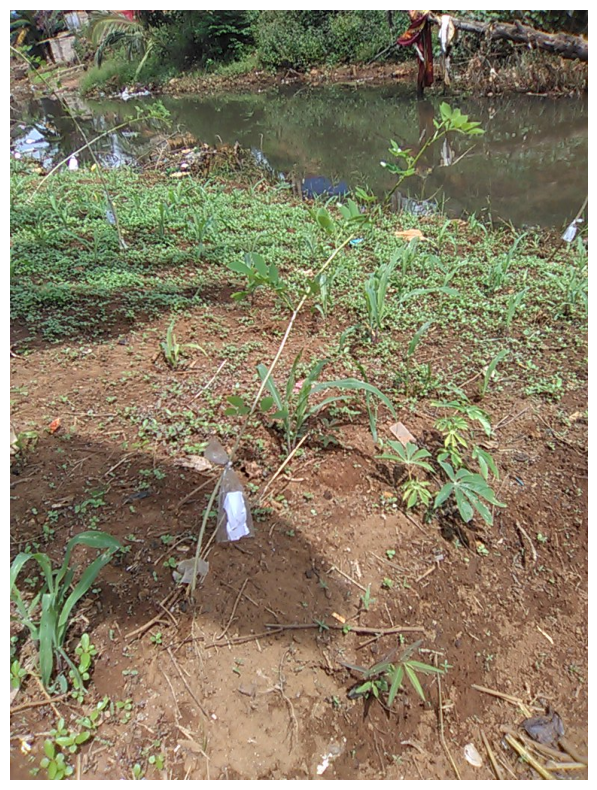

Confidence is 0.6541994112031954
Overlayed mask from deeplab:


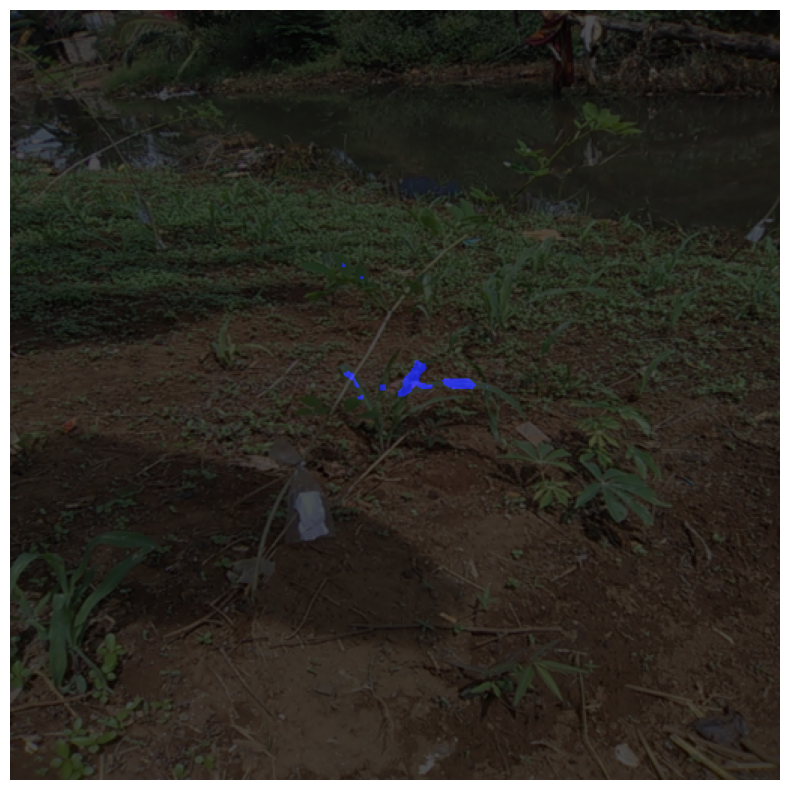

Overlayed mask after CRF:
crf detected nothing.


In [43]:
get_overlayed_mask(inhouse_default,'freetown/GLIRSEPI/2020.11.11.14.39.13_8.38409771_-13.15415501_51b556f2-1248-4b37-84c5-7b2bfe17e5b8_IMG_20201111_130120_2050211254.jpg', my_bucket = bucket )

haiti/MANGINDI/2020.12.10.14.30.02_18.284050477668643_-73.5623668693006_95241edb-21a8-4c5d-805d-27d6ecc89ad1_IMG_20201209_113004_2982436866642572650.jpg
Device: cuda
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
Fixing Image Flipping. Exif tag was 6


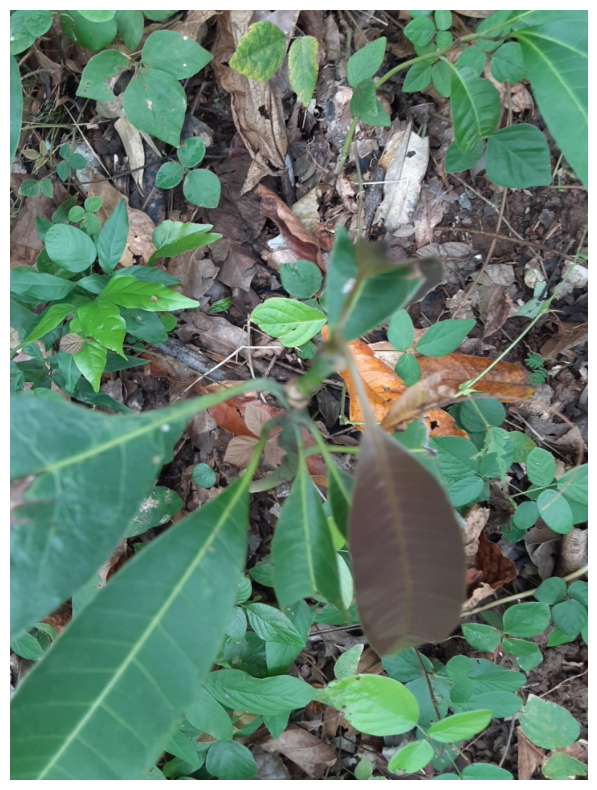

Confidence is 0.8640292309104258
Overlayed mask from deeplab:


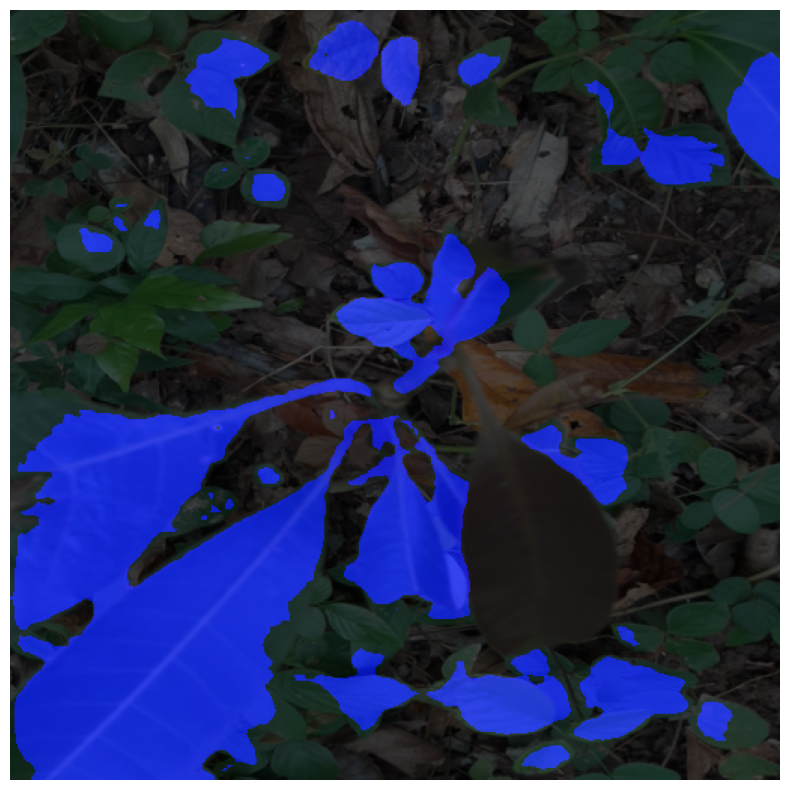

Overlayed mask after CRF:


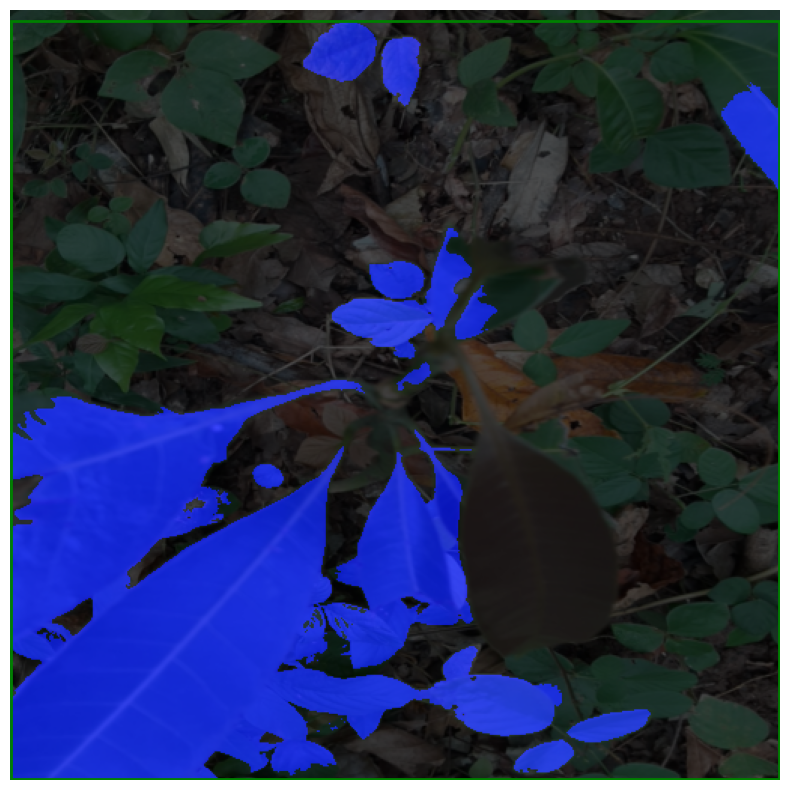

SAM score for this mask is: 0.8157802


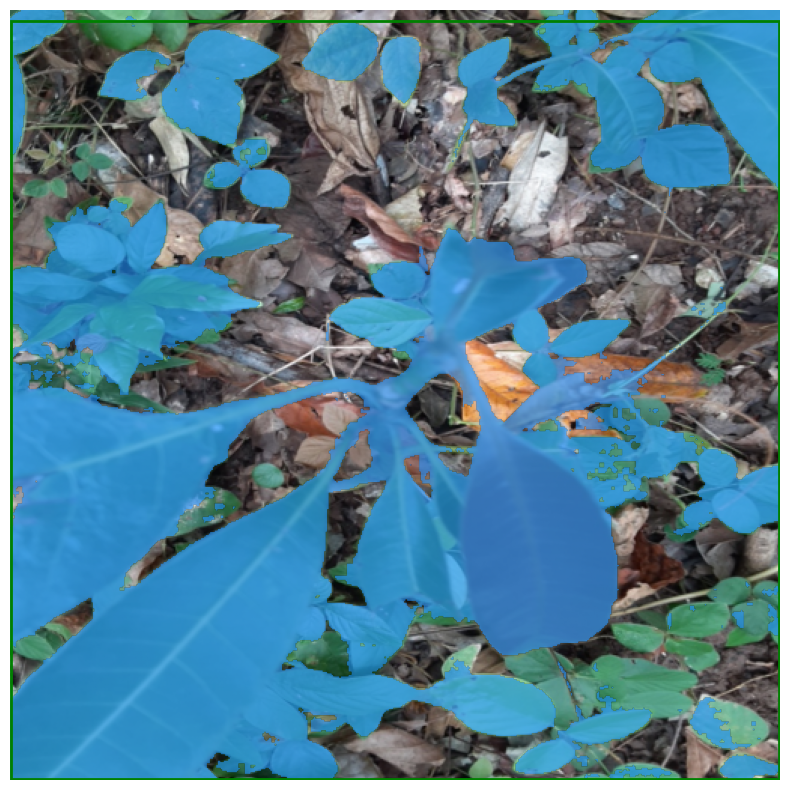

In [41]:
import random 
r = random.randint(0,len(file_list))
print(file_list[r])
get_overlayed_mask(inhouse_default,file_list[r], my_bucket = bucket )